In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import plotly.express as px
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import find_peaks, lombscargle, butter, filtfilt
import plotly.graph_objects as go


In [60]:
def run(fname):
    file = fname.split("/")[-1]
    df = pd.read_csv(fname)
    print(df.keys()[0],df.keys()[1])
    xlab, ylab = df.keys()[0],df.keys()[1]
    df['time (sec)'] = df[xlab] / 1000
    df['neg_amplitude'] = -1*df[ylab]

    sample_rate = 1/np.mean(np.diff(df['time (sec)']))
    nyq = sample_rate/2
    order=4
    low_cutoff= 5
    high_cutoff = 0.5
    low_normal_cutoff = low_cutoff/nyq
    high_normal_cutoff = high_cutoff/nyq
    high_b, high_a = butter(order, high_normal_cutoff, btype='highpass')
    low_b, low_a = butter(order, low_normal_cutoff, btype='lowpass')

    df['filtered_amp'] = filtfilt(high_b, high_a, filtfilt(low_b, low_a, df[ylab]))
    df['neg_filtered_amp'] = -1*df['filtered_amp']

    y_col = 'filtered_amp'
    neg_col = 'neg_filtered_amp'

    peaks = find_peaks(df[y_col], prominence=4, distance=30)
    neg_peaks = find_peaks(df[neg_col], prominence=4, distance=30)

    dicrotic_peaks = find_peaks(df[y_col], prominence=0.20, distance=10)
    dicrotic_peaks = dicrotic_peaks[0][~np.isin(dicrotic_peaks[0], peaks[0])]

    neg_dicrotic_peaks = find_peaks(df[neg_col], prominence=0.20, distance=10)
    neg_dicrotic_peaks = neg_dicrotic_peaks[0][~np.isin(neg_dicrotic_peaks[0], neg_peaks[0])]


    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df['time (sec)'],df[ylab],marker='',linestyle='-',label="")
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Relative Intensity')
    ax.set_title('PPG Signal for '+file)

    # ax.legend()
    # plt.savefig(person_folder+"/scatter_systolic.png")
    plt.savefig(fname.split('.csv')[0]+"_raw.png")
    plt.xlim(10, 20)
    plt.savefig(fname.split('.csv')[0]+"_raw_short.png")
    plt.close()


    # avg = 4;
    # baseline = 100;
    # baselines = [0]* len(df[ylab])
    # points_smooth = [0]* len(df[ylab])
    # for i in range(baseline-1, len(df[ylab])-baseline):
    #     # baselines.append(0);
    #     for j in range(-1*baseline+1, baseline):
    #         # print(df[ylab][0], df[ylab][1], i+j)
    #         baselines[i]  += df[ylab][i+j];
        
    #     baselines[i] /= 2.0*baseline;
    

    # for i in range(avg-1, len(df[ylab])-avg):
    #     # points_smooth.append(0);
    #     for j in range(-1*avg+1,  avg):
    #         points_smooth[i]  += df[ylab][i+j];
        
    #     points_smooth[i] /= 2.0*avg;

    #     points_smooth[i] += -1.0*baselines[i];
    


    # fig, ax = plt.subplots(figsize=(12, 4))
    # ax.plot(df['time (sec)'][baseline+1:-1*(baseline+1)],points_smooth[baseline+1:-1*(baseline+1)],marker='',linestyle='-',label="")
    # ax.set_xlabel('Time (s)')
    # ax.set_ylabel('Relative Intensity')
    # ax.set_title('PPG Signal for '+file)

    # # ax.legend()
    # # plt.savefig(person_folder+"/scatter_systolic.png")
    # plt.show()
    # plt.close()

    # filt2 = filtfilt(high_b, high_a, filtfilt(low_b, low_a, points_smooth[baseline+1:-1*(baseline+1)]))


    # fig, ax = plt.subplots(figsize=(12, 4))
    # ax.plot(df['time (sec)'][baseline+1:-1*(baseline+1)],filt2,marker='',linestyle='-',label="")
    # ax.set_xlabel('Time (s)')
    # ax.set_ylabel('Relative Intensity')
    # ax.set_title('PPG Signal for '+file)

    # # ax.legend()
    # # plt.savefig(person_folder+"/scatter_systolic.png")
    # plt.show()
    # plt.close()

    # # df['time (sec)'] = df['time (sec)'][baseline+1:-1*(baseline+1)]



    fig = px.line(df, x='time (sec)', y=y_col)

    for i in range(len(peaks[0])):
        fig.add_trace(go.Scatter(
        x=[df['time (sec)'].iloc[peaks[0][i]]],
        y=[df[y_col].iloc[peaks[0][i]]],
        mode='markers',
        marker=dict(color='black', size=8),
    ))
        
    for i in range(len(neg_peaks[0])):
        fig.add_trace(go.Scatter(
        x=[df['time (sec)'].iloc[neg_peaks[0][i]]],
        y=[df[y_col].iloc[neg_peaks[0][i]]],
        mode='markers',
        marker=dict(color='red', size=8),
    )) 
        
    for i in range(len(dicrotic_peaks)):
        fig.add_trace(go.Scatter(
        x=[df['time (sec)'].iloc[dicrotic_peaks[i]]],
        y=[df[y_col].iloc[dicrotic_peaks[i]]],
        mode='markers',
        marker=dict(color='green', size=8),
    )) 
            
    for i in range(len(neg_dicrotic_peaks)):
        fig.add_trace(go.Scatter(
        x=[df['time (sec)'].iloc[neg_dicrotic_peaks[i]]],
        y=[df[y_col].iloc[neg_dicrotic_peaks[i]]],
        mode='markers',
        marker=dict(color='purple', size=8),
    )) 
        
    fig.update_layout(showlegend=False)
    # fig.show()
    fig.update_layout(title="Band-pass Filtered PPG signal for "+file)
    fig.write_image(fname.split('.csv')[0]+"_filt.png", width=12*100, height=4*100)

    # Calculate the time step (assuming uniform spacing)
    time = df['time (sec)'].values
    amplitude = df['filtered_amp'].values
    dt = np.mean(np.diff(time))  # or use np.mean(np.diff(time)) if it's not perfectly uniform

    # Compute FFT
    N = len(amplitude)
    yf = fft(amplitude)
    xf = fftfreq(N, dt)[:N//2]  # Take the positive half of the frequencies
    amplitude_spectrum = 2.0/N * np.abs(yf[:N//2])

    # Define frequency slice
    start = 15
    end = int(len(xf) / 3)

    # Smooth using moving average
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), mode='same') / w

    smoothed_amplitude = moving_average(amplitude_spectrum, w=5)  # Adjust window size as needed
    smoothed_amplitude = smoothed_amplitude[start:end]
    xf = xf[start:end]
    # Plot FFT
    plt.figure(figsize=(10, 6))
    plt.plot(xf*60, smoothed_amplitude)
    # plt.xticks(np.arange(min(xf*60), max(xf*60) + 1, 10))  # Ticks every 1 unit
    plt.title("FFT of the Signal for "+file)

    plt.xlabel("Frequency (bpm)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    peak_idx = np.argmax(smoothed_amplitude)
    peak_freq = xf[peak_idx]
    print(f"Simple Max: {xf[peak_idx] * 60}")
    plt.legend([str(xf[peak_idx] * 60)[0:5] + "bpm"])
    plt.savefig(fname.split('.csv')[0]+"_fft.png")
    plt.xlim(0, 140)
    plt.savefig(fname.split('.csv')[0]+"_fft_zoomed.png")
    plt.close()

    # plt.show()



In [61]:
run('data/Jonas/green/6may_3_jonas_muddy.csv')

0 783
Simple Max: 71.83083916972652


In [62]:
import os
def main(person_name, person_folder):
    # Get all CSV files (except baseline)
    all_files = [
        f
        for f in os.listdir(person_folder)
        if f.endswith(".csv")
    ]
    print(all_files)

    #     fname = "data/Jonas/green/28apr_jonas_set2_2.csv"
    for file in all_files:
        fname = person_folder+"/"+file
        run(fname)

In [63]:
if __name__ == "__main__":
    # user = "Sanjay"
    for user in ["Sanjay","Bryan","Jonas"]:
        main(user, f"data/{user}/green")
    for user in ["Sanjay","Bryan"]:
        main(user, f"data/{user}/blue")





['30_apr_sanjay_2.csv', '2_may_sanjay_3.csv', '6_may_sanjay_1_muddy.csv', '6_may_sanjay_4_muddy_valsalva.csv', '30_apr_sanjay_3.csv', '30_apr_sanjay_1.csv', '30_apr_sanjay_4.csv', '3_may_sanjay_3.csv', '2_may_sanjay_1.csv', '3_may_sanjay_1.csv', '6_may_sanjay_2_muddy.csv', '4_may_sanjay_1.csv', '3_may_sanjay_2.csv', '2_may_sanjay_2.csv', 'sanjay_baseline.csv', '6_may_sanjay_3_muddy.csv', '2_may_sanjay_4.csv']
0 714
Simple Max: 84.29960114741124
0 678
Simple Max: 93.07406166578453
0 805
Simple Max: 102.4179736459953
0 805
Simple Max: 101.11811912739388
0 676
Simple Max: 92.20817485402048
0 612
Simple Max: 78.90603045277112
0 622
Simple Max: 88.33317794997218
0 557
Simple Max: 76.90095483805011
0 626
Simple Max: 52.12598913841063
0 617
Simple Max: 76.65015749165056
0 789
Simple Max: 96.5693551988931
0 686
Simple Max: 75.8911579736397
0 591
Simple Max: 73.90960745007861
0 702
Simple Max: 96.37354898353071
0 620
Simple Max: 83.27527569737916
0 819
Simple Max: 98.85139313295808
0 742
Simple

In [64]:
peak_idx = np.argmax(smoothed_amplitude)
peak_freq = xf[peak_idx]

# Window around peak
window = 40  # number of points on each side
start_window = max(peak_idx - window, 0)
end_window = min(peak_idx + window, len(xf))
fit_freqs = xf[start_window:end_window]
fit_vals = smoothed_amplitude[start_window:end_window]
# Gaussian model
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def lorentzian(x, a, x0, gamma):
    return a / (1 + ((x - x0) / gamma)**2)

# Initial guesses
a0 = np.max(fit_vals)
x0 = fit_freqs[np.argmax(fit_vals)]
sigma0 = (fit_freqs[-1] - fit_freqs[0]) / 6

popt, _ = curve_fit(gaussian, fit_freqs, fit_vals, p0=[a0, x0, sigma0])
_, peak_gaussian, _ = popt

popt_l, _ = curve_fit(lorentzian, fit_freqs, fit_vals)
_, peak_lorentzian, _ = popt_l

print(f"Gaussian BPM: {peak_gaussian*60:.3f}")
print(f"Lorentzian BPM: {peak_lorentzian*60:.3f}")
print(f"Simple Max: {xf[peak_idx] * 60}")
plt.plot(xf, smoothed_amplitude, label='FFT')

chi2 = np.sum((smoothed_amplitude[start_window:end_window] - lorentzian(fit_freqs, *popt_l))**2/lorentzian(fit_freqs, *popt_l))
dof = len(smoothed_amplitude[start_window:end_window]) - len(popt_l)
pvalue =  1 - stats.chi2.cdf(chi2, dof)

print(chi2, pvalue)
# plt.plot(fit_freqs, gaussian(fit_freqs, *popt), 'r--', label='Gaussian fit')
plt.plot(fit_freqs, lorentzian(fit_freqs, *popt_l), 'g--', label='Lorentzian fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

NameError: name 'smoothed_amplitude' is not defined

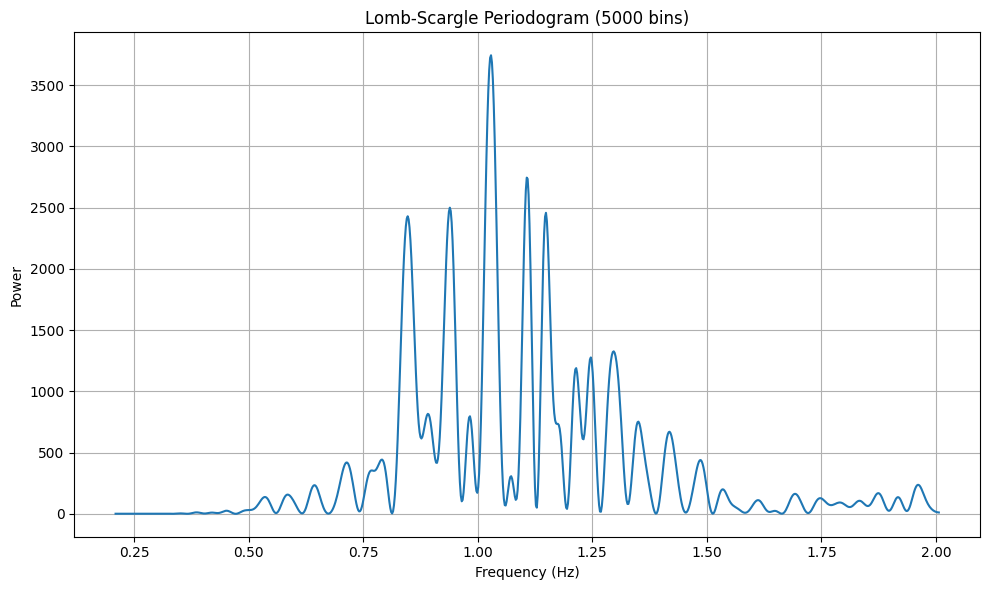

In [ ]:
# Detrend the signal (optional but usually helpful)
amplitude = amplitude - np.mean(amplitude)

# Define frequency range
f_min = 0.01  # Hz, adjust based on your data
f_max = 10    # Hz, or something like 1 / min(np.diff(time)) if unsure

# Convert to angular frequencies (radians/second)
frequencies = np.linspace(f_min, f_max, 5000)
angular_freqs = 2 * np.pi * frequencies

# Compute Lomb-Scargle periodogram
power = lombscargle(time, amplitude, angular_freqs)

start = 100
end = 1000
# Plot
plt.figure(figsize=(10, 6))
plt.plot(frequencies[start:end], power[start:end])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram (5000 bins)")
plt.grid(True)
plt.tight_layout()
plt.show()